In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.integrate as integ
from scipy.spatial import Delaunay
import matplotlib.tri as mtri

from plot_triangulation import plot_triangle, plot_mesh

# Problemas de contorno para Ecuaciones en Derivadas Parciales
En este cuaderno vamos a generalizar al caso de ecuaciones en derivadas parciales la resolución de problemas de contorno unidimensionales para ecuaciones diferenciales ordinarias. 

## Caso modelo: la ecuación de Lapalce

El  **Laplaciano** de una función de dos variables $u(x,y)$ es:
$$
\Delta u := \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2}.
$$
Nuestro objetivo es resolver un problema de contorno para la ecuación:
$$
-\Delta u(x,y) = f (x,y)
$$
en el dominio $\Omega$, con condiciones de frontera $u(x,y)=0$ para $(x,y)\in\partial\Omega$.

En otras palabras: dada un función $f(x,y)$, queremos hallar una función $u(x,y)$ que cumpla:
$$
-\Delta u(x,y) = f (x,y),\quad \text{ para }(x,y)\in\Omega,
$$
$$ 
u(x,y) = 0,\quad \text{ para }(x,y)\in\partial\Omega.
$$

Para ello vamos a seguir las ideas que introdujimos para problemas de contorno en ecuaciones diferenciales ordinarias.

Empezamos definiendo el espacio $\mathbf{V}$ de todas las funciones (diferenciables) $v(x,y)$ definidas para $(x,y)\in\Omega$ que además cumplen que se anulan en el borde de $\Omega$:
$$
v(x,y) = 0\quad \text{para cualquier }\in\partial\Omega.
$$
La ecuación anterior es cierta si y sólo si el producto de $-\Delta u(x,y) - f(x,y) =0$ por cualquier función $v\in \mathbf{V}$ es cero. Si integramos en $\Omega$ el resultado sigue siendo cero:
$$
\int_\Omega \left(-\Delta u(x,y) - f(x,y) \right) v(x,y) dxdy = 0\;\text{ para cualquier }v\in \mathbf{V}.
$$

Esa integral se puede simplificar un poco integrando por partes (usando que $v(x,y)=0$ para cualquier punto $(x,y)$ de la frontera $\partial\Omega$):
$$
\int_\Omega \nabla u(x,y)\cdot \nabla v(x,y)dxdy - \int_\Omega f(x,y) v(x,y)dxdy = 0\;\text{ para cualquier }v\in \mathbf{V}.
$$
Esta ecuación se conoce como **formulación débil** del problema de contorno (el adjetivo débil se justifica por el hecho de que en esta formulación tanto $u$ como $v$ únicamente han de poseer derivadas parciales de orden uno; en contraste con la ecuación de Laplace que exige tener derivadas parciales de orden dos). 

Como hicimos en el caso unidimensional, introducimos el _funcional de energía_:
$$
E(u) = \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dxdy - \int_\Omega f(x,y) u(x,y)dxdy.
$$

La formulación débil no es más que exigir que la derivada $E$ en el "punto" $u$ y en la dirección $v$, sea cero, sea cual sea $v\in\mathbf{V}$. 

> _Cualquier solución de la ecuación diferencial es un punto crítico del funcional de energía, y viceversa._

En otras palabras:

$$
-\Delta u = f\; \text{ en sentido "débil"}\Leftrightarrow \langle\nabla E(u),v\rangle=0 \text{ para cualquier }v\in \mathbf{V}\Leftrightarrow \nabla E(u)=0.
$$

De hecho, el funcional $E$ es cuadrático y convexo, y tiene un único punto crítico, que es un mínimo.

## Elementos finitos 2D

Vamos a extender lo visto sobre la técnica de elementos finitos de una a dos dimensiones. Veremos que tenemos que comprender una serie de cuestiones
- Como se interpola linealmente una serie de nodos $P_i=(x_i,y_i)$ y unos valores $u(x_i,y_i)$ en el caso de funciones de dos variables
- Como se aproximan integrales de funciones de dos variables.

### La elección de los nodos: triangulaciones o mallados

En contraste con lo que ocurre en 1-d, no podemos tomar un conjunto de nodos arbitrario dentro de nuestro dominio $\Omega$.

Los nodos han de poseer una cierta estructura; lo más habitual (y computacionalmente más eficiente) es suponer que los __nodos__ $P_0,P_1,\dots P_N\in\Omega$ son vértices de una __triangulación__ de $\Omega$. 

Comenzaremos por explicar que es __triangular__ (es decir, descomponer en triángulos) un dominio y usaremos como elementos funciones continuas que son lineales a trozos en cada triángulo (esta es la forma en que extendemos la interpolación lineal a trozos a funciones de dos variables).

Las `2` coordenadas de los `N` nodos se almacenan de una manera obvia: en una array `Nx2`.

La información de los triángulos se almacena de una forma muy diferente.

_Los vértices no determinan los triángulos_, pero no necesitamos almacenar en un array las coordenadas de los vértices de cada triángulo. Es suficiente con almacenar en un array `Tx3` los índices que ocupan los `3` vértices en el array de vértices.

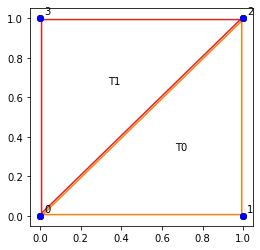

In [2]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [0,1]
])
ivertices_boundary = np.arange(4)

triangles = np.array([
    [0,1,2],
    [0,2,3],
])

plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

Otra triangulación distinta con los mismos nodos.

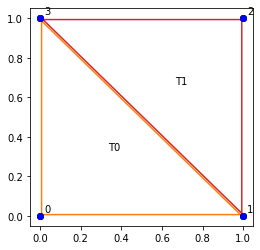

In [3]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [0,1]
])
ivertices_boundary = np.arange(4)

triangles = np.array([
    [0,1,3],
    [1,2,3],
])

plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

In [4]:
def square_mesh(n, L=1):
    nboundary_vertices = 4*n
    ninterior_vertices = (n-1)*(n-1)
    
    nvertices = (n+1)*(n+1)
    vertices = np.zeros((nvertices, 2))
    xx, yy = np.meshgrid(np.linspace(0,L,n+1), np.linspace(0,L,n+1))
    vertices[:,0] = xx.reshape(nvertices)
    vertices[:,1] = yy.reshape(nvertices)
    
    ivertices_boundary = [
        iv for iv in range(nvertices) if
        ((vertices[iv][0]==0) | #south
         (vertices[iv][1]==L) | #east
         (vertices[iv][0]==L) | #north
         (vertices[iv][1]==0)   #west
        )
    ]
    triangles = np.zeros((2*n*n,3), dtype=np.int32)
    itriangle_counter = 0
    for i in range(n):
        for j in range(n):
            triangles[itriangle_counter,:] = [i*(n+1)+j, i*(n+1)+j+1, (i+1)*(n+1)+j]
            triangles[itriangle_counter+1,:] = [i*(n+1)+j+1, (i+1)*(n+1)+j+1, (i+1)*(n+1)+j]
            itriangle_counter += 2

    return vertices, ivertices_boundary, triangles

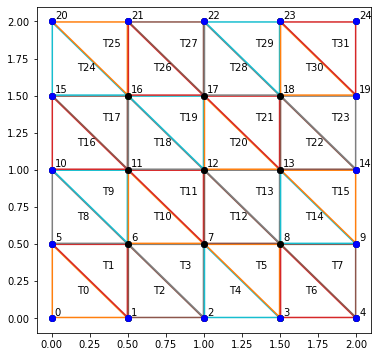

In [5]:
vertices, ivertices_boundary, triangles = square_mesh(4, L=2)
plt.figure(figsize=(6,6))
plot_mesh(vertices,ivertices_boundary,triangles)

Lo más interesante de esta técnica es que se pueden triangular dominios muy variados...

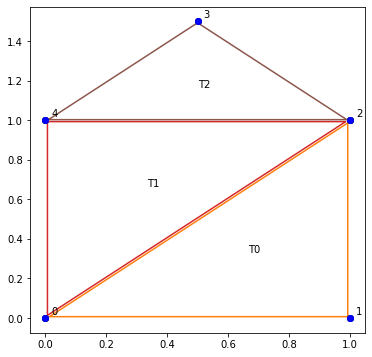

In [6]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [1/2,3/2],
    [0,1]
])
ivertices_boundary = np.arange(5)

triangles = np.array([
    [0,1,2],
    [0,2,4],
    [2,3,4]
])

plt.figure(figsize=(6,6))
plot_mesh(vertices, ivertices_boundary, triangles)

Una técnica útil es buscar vértices que estén repartidos de la forma que nos interese, y luego buscar una __triangulación de Delaunay__, en la que se controla el __aspect ratio__ de los triángulos: el objetivo es que el mayor __diámetro de un triángulo__ de la triangulación sea lo más pequeño posible. Es algo importante para mantener la estabilidad y tener buenas cotas de error. _Si tenemos un triángulo con poca área pero muy alargado la cota de error es grande_.

[[4 2 3]
 [2 4 1]
 [1 4 0]]


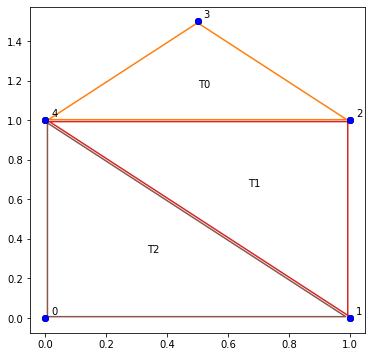

In [7]:
tri = Delaunay(vertices)
print(tri.simplices)
plt.figure(figsize=(6,6))
plot_mesh(vertices, ivertices_boundary, tri.simplices)

Comprobamos en la malla regular que la triangulación de Delaunay no es única (aunque casi siempre lo es).

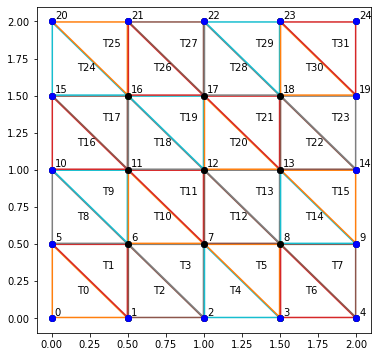

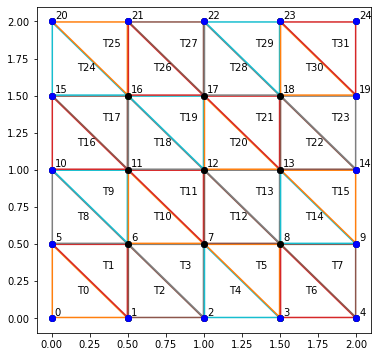

In [8]:
vertices_sq, ivertices_boundary_sq, triangles_sq = square_mesh(4, L=2)
plt.figure(figsize=(6,6))
plot_mesh(vertices_sq, ivertices_boundary_sq, triangles_sq)

triangles_Delaunay = Delaunay(vertices).simplices
plt.figure(figsize=(6,6))
plot_mesh(vertices_sq, ivertices_boundary_sq, triangles_sq)

Usamos la triangulación de Delaunay para refinar una triangulación existente, añadiendo el punto medio de cada segmento de la frontera, y el baricentro de cada triángulo (se puede hacer mejor, pero sirva para ilustrar).

In [9]:
def refine_mesh(vertices, ivertices_boundary, triangles):
    nvertices, _ = vertices.shape
    nvertices_boundary = len(ivertices_boundary)
    nvertices_interior = nvertices - nvertices_boundary
    vertices_boundary = vertices[ivertices_boundary]
    vertices_interior = vertices[[j for j in range(nvertices)
                                  if j not in ivertices_boundary]]
    ntriangles, _ = triangles.shape
    new_nvertices_boundary = 2*nvertices_boundary
    new_ivertices_boundary = np.arange(new_nvertices_boundary)
    new_nvertices_interior = nvertices_interior + ntriangles
    
    new_vertices = np.zeros((new_nvertices_boundary + new_nvertices_interior, 2))
    new_vertices[:new_nvertices_boundary:2, :] = vertices_boundary
    for j in range(nvertices_boundary):
        iv  = ivertices_boundary[j]
        iv1 = ivertices_boundary[(j+1)%nvertices_boundary]
        new_vertices[2*j+1, :] = 0.5*(vertices[iv]+vertices[iv1])
    new_vertices[new_nvertices_boundary:new_nvertices_boundary+nvertices_interior, :] = vertices_interior
    for j in range(len(triangles)):
        triangle = triangles[j]
        v1,v2,v3 = triangle
        vbarycenter = new_nvertices_boundary+nvertices_interior+j
        barycenter = vertices[triangle].mean(axis=0)
        new_vertices[vbarycenter, :] = barycenter
    
    tri = Delaunay(new_vertices)
    new_triangles = tri.simplices
    return new_vertices, new_ivertices_boundary, new_triangles
    

In [10]:
plt.figure(figsize=(4,4))
plot_mesh(vertices, ivertices_boundary, triangles)

plt.figure(figsize=(9,9))
vertices2, ivertices_boundary2, triangles2 = refine_mesh(vertices, ivertices_boundary, triangles)
plot_mesh(vertices2,ivertices_boundary2,triangles2)

plt.figure(figsize=(9,9))
vertices3, ivertices_boundary3, triangles3 = refine_mesh(vertices2, ivertices_boundary2, triangles2)
plot_mesh(vertices3,ivertices_boundary3,triangles3)

vertices4, ivertices_boundary4, triangles4 = refine_mesh(vertices3, ivertices_boundary3, triangles3)
vertices5, ivertices_boundary5, triangles5 = refine_mesh(vertices4, ivertices_boundary4, triangles4)
vertices6, ivertices_boundary6, triangles6 = refine_mesh(vertices4, ivertices_boundary4, triangles4)


### Interpolación lineal a trozos: elementos finitos

Fijamos una serie de nodos $P_0,P_1,\dots,P_{N}\in \Omega$, y una triangulación que tiene a estos nodos como vértices de los triángulos. Supongamos que los diámetros de todos los triángulos son menores que $h>0$.

Buscamos una solución aproximada en el espacio $\mathbf{V}_h$ de funciones continuas que además son lineales en cada triángulo y que valen $0$ en toda la frontera.

Cualquier función de $\mathbf{V}_h$ se puede escribir en la forma
$$
u_h(x,y) = \sum_{i=1}^n c_i\phi_i(x,y)
$$
Donde $\phi_i$ son funciones que forman una base de $\mathbf{V}_h$.

Hemos supuesto que los nodos que corresponden a los puntos interiores (los que no pertenecen a la frontera) son los primeros $n$ nodos. Dado un nodo $P_i$ que __no está en la frontera__ $\partial\Omega$, la función $\phi_i$ es la única función de $\mathbf{V}_h$ que vale $1$ en $P_i$, y $0$ en todos los demás nodos. En cada triángulo es lineal y por lo tanto su gradiente es constante.

El problema consiste en hallar los valores $c_1, c_2, \dots, c_n$ para los que la función $u_h$ mejor aproxima las solución exacta del problema de contorno $u$.

Si desarrollamos el funcional de energía en esta base tenemos:
$$
\begin{array}{rcll}
E(u_h)&=&\frac{1}{2}\int_\Omega |\nabla u_h(x,y)|^2dxdy - \int_\Omega f(x,y) u_h(x,y) dxdy
\end{array}
$$
$$
\begin{array}{rcl}
E\left(\sum_{i=1}^n c_i\phi_i(x,y)\right)&=& \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)\right)dxdy \\
                        &&- \sum_{i=1}^n c_i\int_\Omega f(x,y)\phi_i(x,y)dxdy  = 0
\end{array}
$$

Definimos:
 - Una matriz $A$ cuya entrada $i,j$ es $\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)dxdy$.
 - Un vector $\mathbf{b}$ cuya entrada $i$ es $\int_\Omega f(x,y)\phi_i(x,y)\:dxdy$.
 - Un vector $\mathbf{c}$ cuya entrada $i$ es la incógnita $c_i$.
 
La energía de $u_h$ no es más que:
$$
\begin{array}{rcll}
E(u_h)=E\left(\sum_{i=1}^n c_i\phi_i(x,y)\right)=\frac{1}{2}\mathbf{c}^T\cdot A\cdot \mathbf{c} - \mathbf{c}^T\cdot\mathbf{b}.\\
\end{array}
$$

 Si $x_i$ no es adyacente a $x_j$ en la triangulación, la integral $\int_\Omega\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)dxdy$ es $0$. Si son adyacentes, o iguales, la integral es una suma de integrales sobre triángulos de funciones constantes.

Es decir, __la matriz $A$ tiene muchos ceros__.

El funcional $E$ es cuadrático y definido positivo, y por tanto tiene un mínimo absoluto en su único punto crítico, que se obtiene derivando e igualando a cero:
$$
\nabla E(u_h) = A\cdot \mathbf{c} - \mathbf{b} = \mathbf{0}
$$
y finalmente encontramos una solución de nuestro problema variacional resolviendo un sistema de ecuaciones lineales.

Resumiendo: la aproximación 
$$
u_h(x,y) = \sum_{i=1}^n c_i\phi_i(x,y)
$$
a la solución exacta se calcula obteniendo $\mathbf{c}=(c_1,\dots,c_n)$ resolviendo el sistema de ecuaciones lineales:
$$
A\cdot \mathbf{c} = \mathbf{b}.
$$

### Como calcular `A` y `b`

En vez de rellenar `A` y `b` rellenando el término de la fila `i`, columna `j`, es más fácil recorrer los triángulos, incorporando la contribución de cada triángulo a la matriz `A` y al vector `b`.

Por ejemplo, sobre el triángulo $T$ con vértices $P_i,P_j,P_k$ queremos hacer tres integrales:
$$
\begin{array}{cc}
 & \int_T f(x,y)\phi_i(x,y)\:dx\:dy,\\
 & \int_T f(x,y)\phi_j(x,y)\:dx\:dy,\\
 & \int_T f(x,y)\phi_k(x,y)\:dx\:dy
\end{array}
$$
que debemos sumar a los términos $b_i,b_j,b_k$, respectivamente, como contribuciones distintas a las integrales que las definen:
$$
\begin{array}{cc}
b_i=\int_\Omega f(x,y)\phi_i(x,y)\:dx\:dy,\\
b_j=\int_\Omega f(x,y)\phi_j(x,y)\:dx\:dy,\\
b_k=\int_\Omega f(x,y)\phi_k(x,y)\:dx\:dy.
\end{array}
$$


Observamos la función lineal $\phi_i$, que vale $1$ en el nodo $P_i$ y 0 en el resto de nodos, restringida al triángulo $T$, con vértices 

$$P_i=(x_i,y_i),\quad P_j=(x_j,y_j),\quad P_k=(x_k,y_k).$$

La función verifica este sistema de ecuaciones
$$
\begin{array}{lcr}
  \phi_i(P_i)&=&1\\
  \phi_i(P_j)&=&0\\
  \phi_i(P_k)&=&0
\end{array}
$$
Si desarrollamos $\phi_i(x,y) = a_i x+b_i y+c_i$, las incógnitas son $a,b,c$. Sabemos que satisfacen las ecuaciones:
$$
\begin{array}{lcr}
  a_i x_i+b_i y_i+c_i&=&1\\
  a_i x_j+b_i y_j+c_i&=&0\\
  a_i x_k+b_i y_k+c_i&=&0
\end{array}
$$

En resumen, un sistema lineal de ecuaciones para los coeficientes de $\phi_i$ con matriz de coeficientes $P$:
$$
P=\left(\begin{array}{lcr}
  x_i & y_i &1\\
  x_j & y_j &1\\
  x_k & y_k &1
\end{array}\right)
$$
_lo realmente curioso es que podemos encontrar los coeficientes de $\phi_i$, $\phi_j$, $\phi_k$_ de una sóla vez, invirtiendo la matriz $P$ (ejercicio: piensa por qué).

Una vez calculados los coeficientes $a_i,b_i,c_i$ de $\phi_i$, su gradiente es $\nabla\phi_i=(a_i,b_i)$.

También es gracioso que podemos calcular los productos de todos los gradientes $\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)$ en $T$ mediante un producto de matrices $G^T\cdot G$... observa el código de abajo.

Finalmente, para integrar $f(x,y)\phi_i(x,y)$ en un triángulo de forma aproximada, usamos una regla de cuadratura para triángulos.

La regla siguiente es de orden 1:
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} (f(p_1)+f(p_2)+f(p_3))
$$
donde $|T|$ es el área del triángulo, y $p_1,p_2,p_3$ son sus vértices.

La regla siguiente es de orden 2 (es decir, integra correctamente polinomios de hasta orden 2):
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} \left(f(m_1)+f(m_2)+f(m_3)
\right)
$$
donde $m_1,m_2,m_3$ son los puntos medios de los lados.

Al aplicar la regla de cuadratura de los vértices a $\int_T f(x,y)\phi_i(x,y)\:dxdy$ tenemos:

 - $\int_T f(x,y)\phi_1(x,y)\:dxdy \approx \frac{|T|}{3} (f(p_1)\phi_1(p_1)+f(p_2)\phi_1(p_2)+f(p_3)\phi_1(p_3))=\frac{|T|}{3}f(p_1)$
 - $\int_T f(x,y)\phi_2(x,y)\:dxdy \approx \frac{|T|}{3} (f(p_1)\phi_2(p_1)+f(p_2)\phi_2(p_2)+f(p_3)\phi_2(p_3))=\frac{|T|}{3}f(p_2)$
 - $\int_T f(x,y)\phi_3(x,y)\:dxdy \approx \frac{|T|}{3} (f(p_1)\phi_3(p_1)+f(p_2)\phi_3(p_2)+f(p_3)\phi_3(p_3))=\frac{|T|}{3}f(p_3)$

### Ejercicio

En el código siguiente, encuentra las líneas de código que:

 - Calculan el área del triángulo $T$.
 - Aproximan las integrales $\int_T f(x,y)\phi_i(x,y)\:dxdy$
 - Aproximan las integrales $\int_T\nabla\phi_i(x,y)\cdot\nabla\phi_j(x,y)dxdy$
 - Imponen que u vale 0 en $\partial\Omega$
 - Resuelve el sistema de ecuaciones $A\cdot\mathbf{c}=\mathbf{b}$


In [11]:
def solve_FEM(vs, ivsb, ts, f, g=None):
    nvs, _ = vs.shape
    nvsb = len(ivsb)
    ivs = np.arange(nvs)

    A = np.zeros((nvs,nvs))
    # Vector b
    b = np.zeros(nvs)
    for triangle in ts:
        P = np.ones((3,3))
        P[:,:2] =vs[triangle,:]
        area = la.det(P)/2
        G = la.inv(P)[:2,:]
        #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
        A[np.ix_(triangle, triangle)] += G.transpose()@G*area

        for iv in triangle:
            vertex = vs[iv]
            #Usamos una regla de integración de orden 1
            b[iv] += (area/3)*f(vertex)

    # boundary data
    # Equations for boundary vertices are I*cs_boundary = gs_boundary
    b[ivsb] = [g(x,y) for x,y in vs[ivsb,:]] if g else 0
    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
    A[np.ix_(ivsb, ivs)] = 0
    A[np.ix_(ivsb, ivsb)] = np.eye(nvsb)
    return la.solve(A, b)

Dibujamos usando funciones específicas de `matplotlib`, el color indica el valor de u.

Text(0.5, 1.0, 'solución por elementos finitos con 37 nodos')

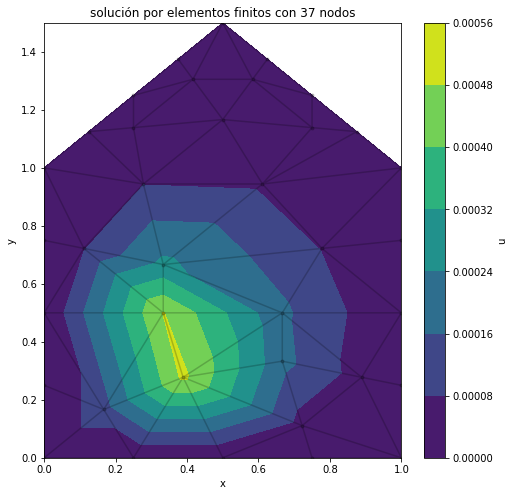

In [12]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0

def f(xs):
    x, y = xs
    return h(x)*h(y)

vs = vertices3
ivsb = ivertices_boundary3
ts = triangles3
cs = solve_FEM(vs, ivsb, ts, f)
# with non-zero Dirichlet boundary condition
# cs = solve_FEM(vs, ivsb, ts, f, lambda x,y:-0.001*x)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 325 nodos')

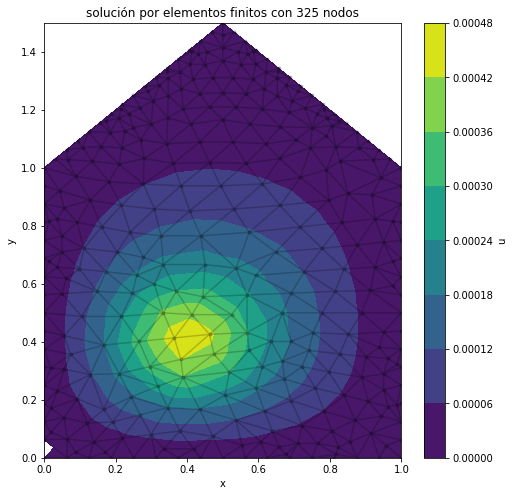

In [13]:
vs = vertices5
ivsb = ivertices_boundary5
ts = triangles5
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

In [14]:
#Máximo de la función u
max(np.abs(cs))

0.0004550890894078764

En un mallado regular...

In [15]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0
# Probamos distintos valores
def f(xs):
    x, y = xs
    return h(x)**2*h(y)

vertices, ivertices_boundary, triangles = square_mesh(20, L= 1)
vs = vertices
ivsb = ivertices_boundary
ts = triangles
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 441 nodos')

Ahora con la regla de orden 2:
La regla siguiente es de orden 2 (es decir, integra correctamente polinomios de hasta orden 2):
$$
\int_T f(x,y)dx\:dy\approx \frac{|T|}{3} \left(f(m_1)+f(m_2)+f(m_3)
\right)
$$
donde $m_1,m_2,m_3$ son los puntos medios de los lados.

Al aplicar la regla de cuadratura de orden 2 a $\int_T f(x,y)\phi_i(x,y)\:dxdy$ tenemos:
- $\int_T f(x,y)\phi_1(x,y)\:dxdy \approx \frac{|T|}{3} (f(mid_{12})\phi_1(mid_{12})+f(mid_{23})\phi_1(mid_{23})+f(mid_{31})\phi_1(mid_{31}))=\frac{|T|}{6}(f(mid_{12})+f(mid_{31}))$
- $\int_T f(x,y)\phi_2(x,y)\:dxdy \approx \frac{|T|}{3} (f(mid_{12})\phi_2(mid_{12})+f(mid_{23})\phi_2(mid_{23})+f(mid_{31})\phi_2(mid_{31}))=\frac{|T|}{6}(f(mid_{23})+f(mid_{12}))$
- $\int_T f(x,y)\phi_3(x,y)\:dxdy \approx \frac{|T|}{3} (f(mid_{12})\phi_3(mid_{12})+f(mid_{23})\phi_3(mid_{23})+f(mid_{31})\phi_3(mid_{31}))=\frac{|T|}{6}(f(mid_{31})+f(mid_{23}))$

In [16]:
def solve_FEM(vs, ivsb, ts, f, g=None):
    nvs, _ = vs.shape
    nvsb = len(ivsb)
    ivs = np.arange(nvs)

    A = np.zeros((nvs,nvs))
    # Vector b
    b = np.zeros(nvs)
    for triangle in ts:
        P = np.ones((3,3))
        P[:,:2] =vs[triangle,:]
        area = la.det(P)/2
        G = la.inv(P)[:2,:]
        #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
        A[np.ix_(triangle, triangle)] += G.transpose()@G*area

        iv1,iv2,iv3 = triangle
        v1,v2,v3 = vs[iv1],vs[iv2],vs[iv3]
        mid12, mid23, mid31 = (v1+v2)/2, (v2+v3)/2, (v3+v1)/2
        #Integramos f*phi_i
        b[iv1] += (area/6)*(f(mid12) + f(mid31))
        b[iv2] += (area/6)*(f(mid12) + f(mid23))
        b[iv3] += (area/6)*(f(mid31) + f(mid23))

    # boundary data
    # Equations for boundary vertices are I*cs_boundary = gs_boundary
    b[ivsb] = [g(x,y) for x,y in vs[ivsb,:]] if g else 0
    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing
    A[np.ix_(ivsb, ivs)] = 0
    A[np.ix_(ivsb, ivsb)] = np.eye(nvsb)
    return la.solve(A, b)

In [17]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0

def f(xs):
    x, y = xs
    return h(x)*h(y)

vs = vertices5
ivsb = ivertices_boundary5
ts = triangles5
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 325 nodos')

In [18]:
def h(t):
    if 0.2 <= t <= 0.4:
        return t - 0.2
    if 0.4 <= t <= 0.6:
        return 0.6 - t
    return 0
# Probamos distintos valores
def f(xs):
    x, y = xs
    return h(x)**2*h(y)

vertices, ivertices_boundary, triangles = square_mesh(20, L= 1)
vs = vertices
ivsb = ivertices_boundary
ts = triangles
cs = solve_FEM(vs, ivsb, ts, f)

plt.figure(figsize=(8,8))
triangulation = mtri.Triangulation(vs[:,0], vs[:,1], ts)
CS = plt.tricontourf(triangulation, cs)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('u')
plt.triplot(vs[:,0], vs[:,1], ts, 'k.-', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('solución por elementos finitos con %d nodos'%len(vs))

Text(0.5, 1.0, 'solución por elementos finitos con 441 nodos')

In [19]:
# el valor máximo de u y el punto donde se alcanza

zmax, imax = max(zip(cs, range(len(cs))))
vertices[imax], zmax

(array([0.4, 0.4]), 6.302952388386237e-05)